# Semantic Searching for Movies
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/RAG_and_Search/Semantic_Search.ipynb)

## Introduction

In this notebook we will implement semantic search feature over a dataset of movies. Given a user `query` we'd like to identify movies that user might be interested in. In order to do this we need to be able to search through a dataset of 1000's (or even more!) of movies and rank each one based on it's semantic relevance to the user query.  

To do this we will follow these steps:
1. Embed our entire movies dataset, which is a subset of the [Movies Dataset](https://www.kaggle.com/datasets/utkarshx27/movies-dataset). This will produce a vector representation of each movie.
2. Upon recieving a user `query` we will embed this using the same model. This will produce a query vector.
3. We will measure the distance between the query vector and each movie vector. Sorting this list will give us movies most semantically similar to the query!
4. We can return the list of the top K movies the user might be interested in.  

<img src="../images/semantic_search.png" width="750">

### Install relevant libraries

In [ ]:
!pip install together

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 2.1 MB/s eta 0:00:00


In [ ]:
import together, os

# Paste in your Together AI API Key or load it
TOGETHER_API_KEY = os.environ.get("TOGETHER_API_KEY")

### Download and View the Dataset

In [ ]:
# Let's get the movies dataset
!wget https://raw.githubusercontent.com/togethercomputer/together-cookbook/refs/heads/main/datasets/movies.json
!mkdir datasets
!mv movies.json datasets/movies.json

In [32]:
import json

with open('./datasets/movies.json', 'r') as file:
    movies_data = json.load(file)

movies_data[:3]

[{'title': 'Minions',
  'overview': 'Minions Stuart, Kevin and Bob are recruited by Scarlet Overkill, a super-villain who, alongside her inventor husband Herb, hatches a plot to take over the world.',
  'director': 'Kyle Balda',
  'genres': 'Family Animation Adventure Comedy',
  'tagline': 'Before Gru, they had a history of bad bosses'},
 {'title': 'Interstellar',
  'overview': 'Interstellar chronicles the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage.',
  'director': 'Christopher Nolan',
  'genres': 'Adventure Drama Science Fiction',
  'tagline': 'Mankind was born on Earth. It was never meant to die here.'},
 {'title': 'Deadpool',
  'overview': 'Deadpool tells the origin story of former Special Forces operative turned mercenary Wade Wilson, who after being subjected to a rogue experiment that leaves him with accelerated healing powers, ado

### 1. Generate Embeddings

We will use the Together AI embedding API to generate vector representations for each movie `title` + `overview` + `tagline`.

In [40]:
from typing import List

def generate_embeddings(input_texts: List[str], model_api_string: str) -> List[List[float]]:
    """Generate embeddings from Together python library.

    Args:
        input_texts: a list of string input texts.
        model_api_string: str. An API string for a specific embedding model of your choice.

    Returns:
        embeddings_list: a list of embeddings. Each element corresponds to the each input text.
    """
    together_client = together.Together(api_key = TOGETHER_API_KEY)
    outputs = together_client.embeddings.create(
        input=input_texts,
        model=model_api_string,
    )
    return [x.embedding for x in outputs.data]


In [ ]:
# Concatenate the title, overview, and tagline of each movie
# this makes the text that will be embedded for each movie more informative
# as a result the embeddings will be richer and capture this information. 
to_embed = []
for movie in movies_data[:1000]:
    text = ''
    for field in ['title', 'overview', 'tagline']:
        value = movie.get(field, '')
        text += str(value) + ' '
    to_embed.append(text.strip())

to_embed[:10]

['Minions Minions Stuart, Kevin and Bob are recruited by Scarlet Overkill, a super-villain who, alongside her inventor husband Herb, hatches a plot to take over the world. Before Gru, they had a history of bad bosses',
 'Interstellar Interstellar chronicles the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage. Mankind was born on Earth. It was never meant to die here.',
 'Deadpool Deadpool tells the origin story of former Special Forces operative turned mercenary Wade Wilson, who after being subjected to a rogue experiment that leaves him with accelerated healing powers, adopts the alter ego Deadpool. Armed with his new abilities and a dark, twisted sense of humor, Deadpool hunts down the man who nearly destroyed his life. Witness the beginning of a happy ending',
 'Guardians of the Galaxy Light years from Earth, 26 years after being abducted,

In [57]:
embeddings = generate_embeddings(to_embed, 'BAAI/bge-base-en-v1.5')

In [58]:
# Check the shape of each vector embedding to make sure it is 768 dimensions
len(embeddings[0])

768

### What does a movie vector "look" like?

Here we visualize the vector representation the `bge-base-en-v1.5` produced for the Minions movie at index 0!

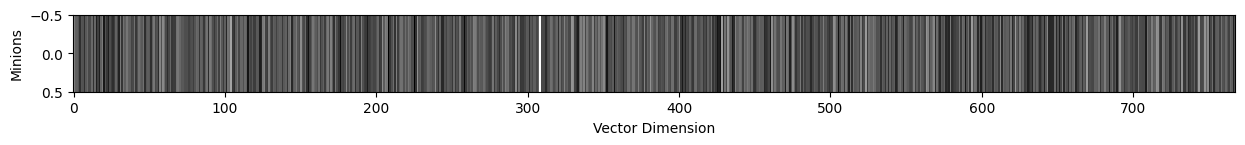

In [60]:
import matplotlib.pyplot as plt
import numpy as np

data = embeddings[0]

data_2d = np.reshape(data, (1, 768))

plt.figure(figsize=(15, 1))
# Create a heatmap with a binary colormap (black and white)
plt.imshow(data_2d, cmap='binary', interpolation='nearest', aspect='auto')

# Remove axes and ticks
plt.xlabel('Vector Dimension')
plt.ylabel(f"{movies_data[0]['title']}")
# Show the plot
plt.show()

A single vector looks alot like a barcode! 

In the plot above you can ignore the `y-axis`. The `x-axis` captures each dimension of the 768 dimensional vector, the colour captures the values at each dimension.

Let's visualize some more vectors to see if we can find patterns!

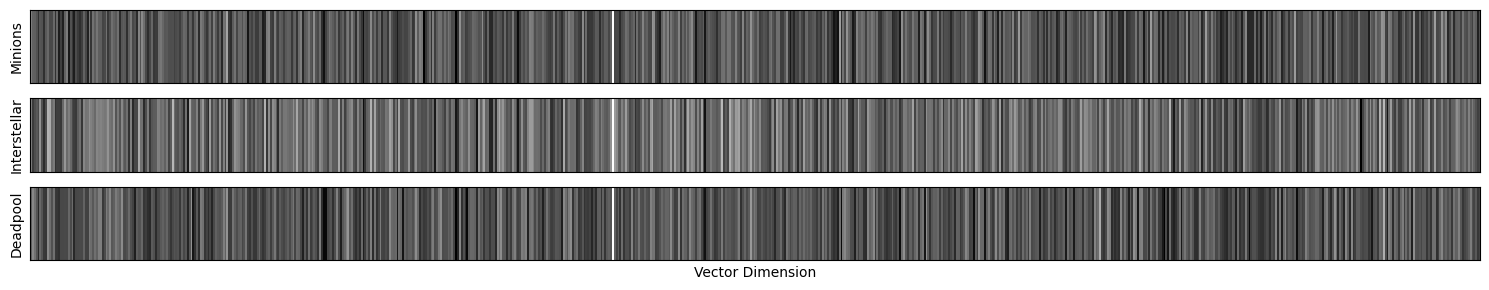

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Select three movie embeddings
data1 = embeddings[0]
data2 = embeddings[1]
data3 = embeddings[2]

# Reshape each embedding into a 2D array
data1_2d = np.reshape(data1, (1, 768))
data2_2d = np.reshape(data2, (1, 768))
data3_2d = np.reshape(data3, (1, 768))

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 3))

# Plot each embedding as a heatmap
axs[0].imshow(data1_2d, cmap='binary', interpolation='nearest', aspect='auto')
axs[1].imshow(data2_2d, cmap='binary', interpolation='nearest', aspect='auto')
axs[2].imshow(data3_2d, cmap='binary', interpolation='nearest', aspect='auto')

# Set labels and titles
axs[0].set_ylabel(f"{movies_data[0]['title']}")
axs[1].set_ylabel(f"{movies_data[1]['title']}")
axs[2].set_ylabel(f"{movies_data[2]['title']}")
axs[2].set_xlabel('Vector Dimension')

# Remove ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

# Layout so plots do not overlap
fig.tight_layout()

# Show the plot
plt.show()

The vectors for the three movies above capture the semantics of the movie title + overview + tagline!

When trying to understand what a vector looks like it better to look at the overall pattern of the barcode as opposed to asking what each line in the barcode means. Each line in the barcode might not have a human understandable meaning - experts don't yet understand how each bar contributes to capturing the overall meaning of the movie!

Next let's visualize the user query!

## 2. Vectorize the User Query

In this case the user is interested in `query` = `super hero action movie with a timeline twist` and so we want to rank our dataset of 1000 movies such that relevant movies are at the top of the list we send to this user.

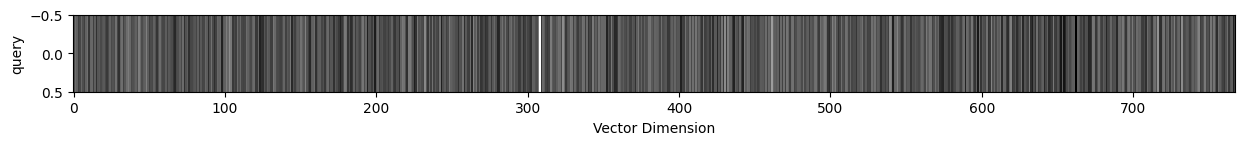

In [ ]:
query = "super hero action movie with a timeline twist"

query_embedding = generate_embeddings([query], 'BAAI/bge-base-en-v1.5')[0]

data_2d = np.reshape(query_embedding, (1, 768))

plt.figure(figsize=(15, 1))
# Create a heatmap with a binary colormap (black and white)
plt.imshow(data_2d, cmap='binary', interpolation='nearest', aspect='auto')

# Remove axes and ticks
plt.xlabel('Vector Dimension')
plt.ylabel("query")
# Show the plot
plt.show()

The `query` vector also looks like a barcode.

The problem of solving which movie is most semantically similar to the user query is the same as asking which movie vector/barcode "looks" most similar to the query vector/barcode!

## 3. Compute Distance between Query and Movie Vectors

Here we will use the cosine similarity metric to identify which movie vectors are closest to the query vector. Intuitively think of this step as matching the qeury barcode to the movie barcodes to find the best match!

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

# This function will produce a list of cosine similarity scores between the query embedding and the movie embeddings
similarity_scores = cosine_similarity([query_embedding], embeddings)

In [ ]:
# We get a cosine similarity score for each one of the 1000 movie embeddings
similarity_scores.shape

(1, 1000)

In [ ]:
# Cosine similarity goes from -1 to 1, where 1 means the vectors are identical and -1 means they are opposite.
similarity_scores[0, :10]

array([[0.46008251, 0.37319415, 0.4377874 , 0.48804997, 0.47663684,
        0.3849754 , 0.42823866, 0.43224164, 0.42884381, 0.54375748]])

## 4. Sort Movies based on Semantic Similarity

We want to organize our list of 1000 movies from most to least relevant to the query. We can do this by sorting the above `similarity_scores` array.

In [ ]:
# Get the indices of the highest to lowest cosine similarity values
# This tell use which movies are most similar to the query

# Lookin at the results below we see that the movie at index 172 is the most similar to the query!
indices = np.argsort(-similarity_scores)

print(indices)

[[172 265 768 621 929 828  49 653 420  33  36 174 187   3  17 535  52 227
  933 585 875 990 961  67   9  11 424 677 478 325 633 185 883 957 638  10
  175 688 140  22 259 839 872 944  18 834 701 356 746 742  76  50  81 321
  295  13  94 241 488 328 650 248 312 788 879 958 191 195 433 429 214 366
  573 385 368 268 815 402 751 217 724 891 209 912 721 772 388  62 606 423
  316 147 977 904 216 394 680 506 641 439 180 715 703 580 838 462 319 723
  830 748 451 367 915 157 468 330  56 298 119 485 973 118 636 162 757 297
  148 941 357 993 637 775 124 252  24 407 455 999 730 733 305 716 350 120
  816  55 129 452 563 579 597 427 948 132 291 336 145 555 804 401   2 571
  487 222 115 590 862 342 675 111 289 229 928 967 871 952 765 610 735 591
  156 417 669 924 920 600 116 574 137 346 840 905 890 276 234 466 554 304
  536 526 138  47 233 173 991 499 131 889 966 467 287 900 309 615 690 481
  836 179  35 165  80 620 280 326 263 130 352 693 383 211 533  15 863 318
  286 296 672 964 561  77 349 911  26 

In [ ]:
top_10_sorted_titles = [movies_data[index]['title'] for index in indices[0]][:10]

top_10_sorted_titles

['The Incredibles',
 'Watchmen',
 'Mr. Peabody & Sherman',
 'Due Date',
 'The Next Three Days',
 'Super 8',
 'Iron Man',
 'After Earth',
 'Men in Black 3',
 'Despicable Me 2']

Here we can see the list of top ten movies most similar to the query(`super hero action movie with a timeline twist`), according to vector embeddings generated by `bge-base-en-v1.5`.

Notice that most of these movies have something to do with the query. Some are super hero movies, some are action movies and others have a timeline twist - we get very few false positives(movies that have nothing to do with anything in the query).

Semantic similarity gives us a fuzzy way to sort our dataset based on how similar the objects are to a given query!

Learn more about how to use embedding models in the [docs](https://docs.together.ai/docs/embeddings-overview) here!